In [1]:
#librarys
import math
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


In [2]:
# data reading 
dateparse = lambda ts: (datetime.fromtimestamp(int(ts))).strftime("%Y%m%d")
df = pd.read_csv("./data/2021-01-01_2021-05-31_ethereumprice_org.csv", \
                     parse_dates=['timestamp'], index_col='timestamp', \
                     date_parser=dateparse)

# Make date ascending
df = df.sort_values("timestamp")

# drop unuse column
df = df.drop(columns = ['high', 'low', 'close'])

# remove duplicate value
# observe that has duplicate value 3/20 and 5/2
df = df.groupby(df.index).first() # only keep the first


#create a new df with only 'open' column
data = df.filter(['open'])
dataset = data.values

In [3]:
#get the number of train model
training_data_len = 120     

In [4]:
#global parameters
num_preday = 5
num_neurons = 50
batch_size = 8
epochs = 100

In [5]:
#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)    


In [6]:
#create the scaled training data set
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
for i in range(num_preday,len(train_data)):
    x_train.append(train_data[i-num_preday:i, 0])
    y_train.append(train_data[i, 0])

In [7]:
#convert to np array
x_train = np.array(x_train)
y_train = np.array(y_train)

In [8]:
#reshape the data
x_train = np.reshape( x_train ,(x_train.shape[0], x_train.shape[1], 1))

In [9]:
#build LSTM model
model = Sequential()
model.add(LSTM(num_neurons, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(num_neurons, return_sequences=False))
model.add(Dense(25))    
model.add(Dense(1))

In [10]:
#compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [11]:
#train the model
history=model.fit(x_train, y_train, batch_size, epochs, validation_split=0.2)


Epoch 1/100
12/12 [==============================] - 16s 97ms/step - loss: 0.0472 - val_loss: 0.0156
Epoch 2/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0060 - val_loss: 0.0254
Epoch 3/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0268
Epoch 4/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0156
Epoch 5/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0183
Epoch 6/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0091
Epoch 7/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0105
Epoch 8/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0058
Epoch 9/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 10/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 1

12/12 [==============================] - 0s 6ms/step - loss: 8.1059e-04 - val_loss: 0.0015
Epoch 83/100
12/12 [==============================] - 0s 6ms/step - loss: 8.4035e-04 - val_loss: 0.0015
Epoch 84/100
12/12 [==============================] - 0s 6ms/step - loss: 6.1045e-04 - val_loss: 0.0017
Epoch 85/100
12/12 [==============================] - 0s 6ms/step - loss: 7.6180e-04 - val_loss: 0.0015
Epoch 86/100
12/12 [==============================] - 0s 6ms/step - loss: 8.0033e-04 - val_loss: 0.0015
Epoch 87/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 88/100
12/12 [==============================] - 0s 6ms/step - loss: 7.8756e-04 - val_loss: 0.0017
Epoch 89/100
12/12 [==============================] - 0s 6ms/step - loss: 7.3723e-04 - val_loss: 0.0024
Epoch 90/100
12/12 [==============================] - 0s 5ms/step - loss: 8.5405e-04 - val_loss: 0.0017
Epoch 91/100
12/12 [==============================] - 0s 5ms/step - loss: 6.3065e

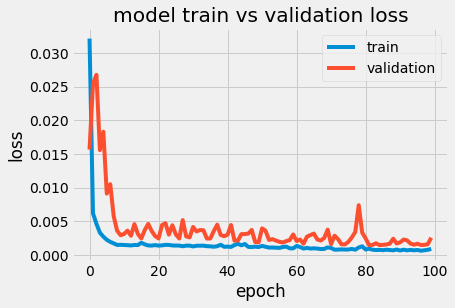

In [12]:
#visualize loss to get a great epoch number
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [13]:
#create test dataset
test_data = scaled_data[training_data_len - num_preday: ,  :]
x_test = []
y_test = dataset[training_data_len: , :]
for i in range(num_preday, len(test_data)):
    x_test.append(test_data[i-num_preday:i, 0])

In [14]:
#convert test data to np array and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
#get the models predicted prices
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [16]:
#get RMSE
rmse = []
sq_err=0.0
for i in range(0,31):
    sq_err+=(predictions[i]-y_test[i])**2
rmse.append(math.sqrt(sq_err/31))
rmse

[384.72073659015734]

<ipython-input-17-2031df27e0a6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<function matplotlib.pyplot.show(close=None, block=None)>

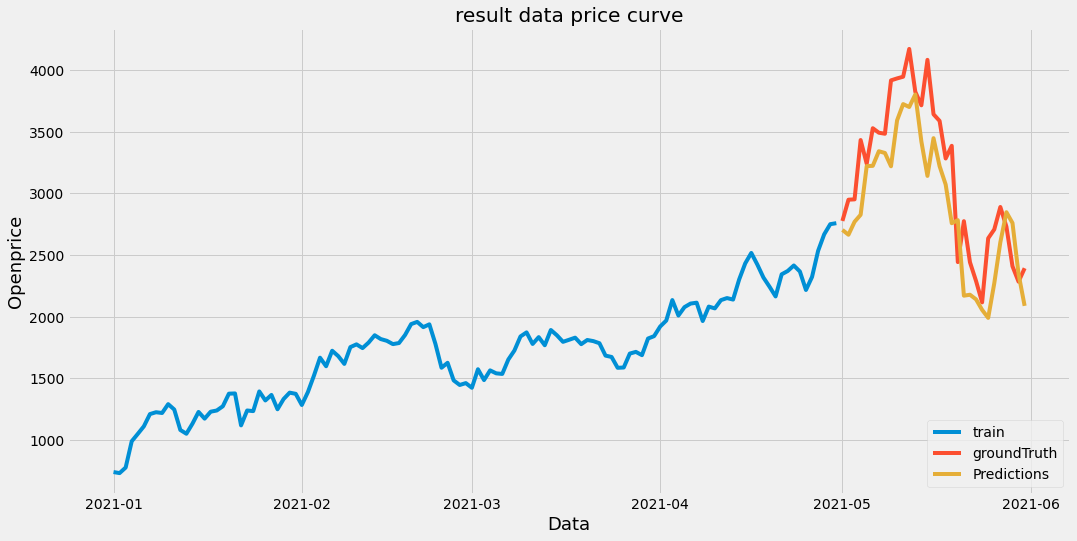

In [17]:
#plot the result
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#visualizeing
plt.figure(figsize=(16,8))
plt.title('result data price curve')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Openprice', fontsize=18)
plt.plot(train['open'])
plt.plot(valid[['open','Predictions']])
plt.legend(['train','groundTruth','Predictions'], loc='lower right')
plt.show